# Expanding Nutri-Score : take your menu to the next level

### Abstract
The nutrition is a major issue in the Western civilization. The bad eating habits are becoming one of the main causes of illness in the world, with very heavy impact on public health. Recently, the various products are being graded through nutrition benefits indices, as for example Nutri-Score. 
Nutri-Score can give an accurate estimation on how healthy an ingredient can be. However, if it can make sense at the ingredient scale, the concept of Nutri-Score would be way more valuable if it were computed considering wider time spans instead of individual ingredients. Indeed, in its present version, Nutri-Score would always give a very high grade to white rice, for example. However, if you only eat white rice, your overall nutrition will not be optimal. The present computation of Nutri-Score is strongly limited, as it is unable to contextualize the consumption of a certain product in regard with the daily feeding practises.

### Millestone 2
During this millestone 2, we perform different task to understand our database what is inside and how to improve it. 
* First of all, we clean our database. The users who fill the database of OpenFoodFacts do errors so we have to detect and correct them.
* After that, we fill the database using nearest neighbours that we compute ourself and suggest also different filling method for later use.
* After the filling, we are able to visualize our database.
* Finally, we perform our Nutri-Score algorithm using as reference <a href= "http://agriculture.gouv.fr/telecharger/87510?token=537276c9f22122955add7292abbcce0d">the document of the Ministry of Agriculture of France [in French].</a>

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix

from random import randint

import matplotlib.pyplot as plt
import seaborn as sns

from computeNutriScore import computeNutriScore

import warnings
warnings.filterwarnings('ignore')

%run Data_scrapping_USagriculture.ipynb

DATA_FOLDER = './data/'

## OpenFoodFacts Dataset Exploration

In this millestone 2 , we will not using all the column that OpenFoodFacts provided to us, we will use :
* `code` : Barcode of the product
* `product_name` : Name of the product 
* `categories_tags` : Tags that describe the product into categories
* `energy_100g` : Amount of energy in the product [kJ] per 100g/100ml
* `fat_100g` : Amount of fats in the product [g] per 100g/100ml
* `saturated-fat_100g` : Amount of subacategories of fats (saturated-fat) in the product [g] per 100g/100ml
* `sugars_100g` : Amount of sugars in the product [g] per 100g/100ml
* `salt_100g` : Amount of salt in the product [g] per 100g/100ml
* `sodium_100g` : Amount of subcategories of salt (sodium) in the product [g] per 100g/100ml
* `fruits-vegetables-nuts_100g` : Ratio of Fruits/Vegetables/Nuts really inside the product [%] per 100g/100ml
* `fruits-vegetables-nuts-estimate_100g` : Ratio of Fruits/Vegetables/Nuts estimated inside the product [%] per 100g/100ml
* `fiber_100g` : Amount of fiber in the product [g] per 100g/100ml
* `proteins_100g` : Amount of protein in the product [g] per 100g/100ml
* `nutrition_grade_fr` : Grade of the product (provided by OpenFoodFacts)
* `nutrition-score-fr_100g` : Score of the product (provided by OpenFoodFacts)

### Loading & Cleaning

We use <a href = "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv">the database provided by OpenFoodFacts</a> (24.11.2018). 

In [2]:
# Load Data and Clean
data_raw = pd.read_csv(DATA_FOLDER + 'en.openfoodfacts.org.products.csv', delimiter = '\t', low_memory = False)
data_clean = data_raw.copy()

# Drop duplicates according to the code
data_clean.drop_duplicates(subset = 'code', keep = False, inplace = True)
data_clean.set_index('code', inplace = True)

# Drop product without product name and without tags
data_clean = data_clean[~data_clean.product_name.isna() & ~data_clean.categories_tags.isna()]

First of all, we delete the duplicates according to the barcode of the products. Indeed, it is logical that two unique products do not have the same barcode. We do not keep one duplicate because we can not decide wich one is correct. All of our algorithms use `categories_tags` to categorize a product, so we clean also all the product where the user gave no tags. There are several categories_tags that OpenFoodFacts provided (`categories`, `categories_tags`, `categories_fr`) but we decide to keep `categories_tags` because it seems to be more complete.

In [3]:
# Create 2 DataFrame - one for only food (useful for compute NutriScore) and an other one with the left columns
column_for_data_food = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                            'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                            'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']

data_food = data_clean[column_for_data_food]

data_clean.drop(column_for_data_food, axis = 1, inplace = True)


We will use a more condensed database (`data_food`) because we do not need the other informations yet.

In [4]:
data_food.head()

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0000000001281,Tarte noix de coco,"en:pies,en:sweet-pies,en:coconut-pies",1594.0,22.0,15.5,21.9,0.100,0.039370,NaN,NaN,4.4,4.6
0000000001885,Compote de poire,"en:plant-based-foods-and-beverages,en:plant-ba...",657.0,0.0,0.0,27.0,0.000,0.000000,NaN,NaN,3.6,0.6
0000000005470,BAguette bressan,"en:plant-based-foods-and-beverages,en:plant-ba...",669.0,2.2,0.5,0.6,0.358,0.140945,NaN,NaN,1.6,9.5
0000000005661,Pavé de saumon fumé à la ficelle,"en:seafood,en:fishes,en:salmons,en:smoked-fish...",1059.0,17.0,2.6,0.5,2.500,0.984252,NaN,NaN,NaN,23.0
0000000020114,Naturablue original,en:dietary-supplements,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0


In [5]:
data_food.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,1.544100e+05,152856.000000,150099.000000,150554.000000,149064.000000,149061.000000,2968.000000,7755.000000,8.076100e+04,153634.000000
mean,1.205114e+03,14.579097,5.756433,16.819036,3.151194,1.240686,43.532483,43.567305,6.897199e+04,7.465736
std,1.262782e+04,186.324021,50.591052,339.402159,177.133061,69.720352,33.567854,29.730224,1.959992e+07,49.972714
min,0.000000e+00,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-2.000000e+01,-5.560000
25%,3.560000e+02,0.500000,0.100000,1.000000,0.032000,0.012598,12.000000,13.700000,0.000000e+00,1.000000
50%,1.000000e+03,5.900000,1.700000,4.500000,0.380000,0.149606,43.000000,50.000000,1.500000e+00,5.100000
75%,1.653000e+03,21.200000,7.400000,19.600000,1.180000,0.464567,65.000000,62.500000,3.400000e+00,9.637500
99%,3.700000e+03,93.000000,42.000000,82.000000,11.900000,4.685039,100.000000,100.000000,2.014000e+01,31.000000
max,2.790000e+06,66700.000000,10000.000000,86700.000000,50800.000000,20000.000000,100.000000,100.000000,5.570000e+09,11800.000000


We see that `sugars_100g`, `fiber_100g` and `proteins_100g` have incoherent values (negative values). There is products with a huge energy value, so we decide to put a limit at 4'000 kJ for 100g/100ml. This criterion is based to the 99% quantile of `energy_100g`. These outliers are set to NaN. The other columns of food have also erroneous values. It is incoherent to have a value larger than 100g because the column represent the amount of sugars, for example, per 100g of the product. 

In [6]:
def Complete_ratio_column(df):
    '''Give an idea of the filling of the columns of a given dataset'''
    for column in df.columns:
        ratio = len(df[[column]].dropna()) * 100/len(df)
        print("For {}, {} % is complete".format(column, round(ratio, 3)))
        
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 86.184 % is complete
For fat_100g, 85.317 % is complete
For saturated-fat_100g, 83.778 % is complete
For sugars_100g, 84.032 % is complete
For salt_100g, 83.2 % is complete
For sodium_100g, 83.199 % is complete
For fruits-vegetables-nuts_100g, 1.657 % is complete
For fruits-vegetables-nuts-estimate_100g, 4.328 % is complete
For fiber_100g, 45.077 % is complete
For proteins_100g, 85.751 % is complete


We observe that some columns are more complete than others. It is normal that the real ratio of fruits/vegetables/nuts is low because it is rarely provided in the list of ingredients (sadly not legally mandatory) and users can also not really estimate this ratio. The fiber content is also low compared to the others but we can think that it is due to the beverages that do not have this information. 

In [7]:
def Compute_energy(Fat, Sugar, Prot, Fiber, Marge):
    '''Compute energy with a marge in kJ source : https://en.wikipedia.org/wiki/Food_energy'''

    energy = (37 * Fat + 17 * (Sugar + Prot) + 8 * Fiber) - Marge
    if energy < 0:
        return 0
    return energy

In [8]:
# Put NaN for incoherent values or give a valid value
def Coherent_value(df):
    """ Compute coherent value for food values """
    for i in range(len(df)):
        
        # energy
        value = df.iat[i, 2]
        if  value < 0 or value > 4000:
            df.iat[i, 2] = np.nan
        
        #other column
        for column in range(3, len(df.columns)):
            value = df.iat[i, column]
            if (value < 0) or (value > 100):
                df.iat[i, column] = np.nan
                
        # Salt / Sodium        
        if np.isnan(df.iat[i, 6]):
            if ~np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 7] * 2.5) <= 100):
                    df.iat[i, 6] = df.iat[i, 7] * 2.5 # Salt = Sodium * 2.5
                else:
                    df.iat[i, 7] = np.nan # Sodium must be a error value
        else:
            if np.isnan(df.iat[i, 7]):
                if ((df.iat[i, 6] / 2.5) <= 100):
                    df.iat[i, 7] = df.iat[i, 6] / 2.5 # Sodium = Salt / 2.5
                else:
                    df.iat[i, 6] = np.nan # Salt must be a error value
        
        # Saturated Fat / Fats                   
        if df.iat[i, 4] > df.iat[i, 3]: #saturated fat > fat
            df.iat[i, 3] = df.iat[i, 4]
        
        # Fruit-Vegetables-Nut Real / Estimate
        if ~np.isnan(df.iat[i, 8]) & np.isnan(df.iat[i, 9]):
            df.iat[i, 9] = df.iat[i, 8] #Estimate fruits-vegetables-nuts = Real
        if ~np.isnan(df.iat[i, 8]) & (df.iat[i, 9] > df.iat[i, 8]):
            df.iat[i, 9] = df.iat[i, 8]
        
        # Energy
        Fat, Sugar, Prot, Fiber = 0,0,0, 0
        if ~np.isnan(df.iat[i, 3]):
            Fat = df.iat[i, 3]
                
        if ~np.isnan(df.iat[i, 5]):
            Sugar = df.iat[i, 5]
                
        if ~np.isnan(df.iat[i, 11]):
            Prot = df.iat[i, 11]
            
        if ~np.isnan(df.iat[i, 10]):
            Fiber = df.iat[i, 10]
            
        energy_comput = Compute_energy(Fat, Sugar, Prot, Fiber, 150)
        
        if np.isnan(df.iat[i, 2]) | (df.iat[i, 2] < energy_comput):
            df.iat[i, 2] = energy_comput       
            
    return df

data_food = Coherent_value(data_food)

To clean our database, we check if the values (if provided) is inside a coherent range. We see it later but some product have more saturated-fat than fats so we detect these kind of incoherent values. The Salt-Sodium ratio is 2.5 so we also check this relation and we can already fill salt or sodium if a product lacks either one or the other. We also check if the estimated content fruits/vegetables/nuts is more than the real one and we can fill the estimated one if it is missing by the real one, in order to facilitate later completion. We also compute a theoritical energy value with a margin of 150kJ, based on the <a href= "https://en.wikipedia.org/wiki/Food_energy#Nutrition_labels">energy density of nutrients.</a> The products can not have less energy than this baseline value. 

In [9]:
data_food.describe()

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,179163.000000,152808.000000,150074.000000,150471.000000,148888.000000,148888.000000,2968.000000,10687.000000,80731.000000,153596.000000
mean,949.697187,13.731709,5.391913,14.004843,1.124271,0.442637,43.532483,43.496900,2.720258,7.027255
std,853.628100,18.751121,8.798007,19.699353,4.788683,1.885562,33.567854,30.824133,4.595933,7.893487
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,186.000000,0.500000,0.100000,1.000000,0.030480,0.012000,12.000000,13.000000,0.000000,1.000000
50%,766.000000,5.900000,1.700000,4.500000,0.380000,0.149606,43.000000,48.000000,1.500000,5.100000
75%,1556.000000,21.200000,7.400000,19.400000,1.168400,0.460000,65.000000,63.000000,3.400000,9.600000
max,5849.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


In [10]:
data_food[data_food.energy_100g > 4000]

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0204296022634,boufor,"en:dairies,en:fermented-foods,en:fermented-mil...",5849.0,87.0,76.00,66.0,6.0000,2.362205,NaN,NaN,67.0,66.0
3250390000532,Bouton D Or Huile Mais,en:fats,5250.0,100.0,NaN,50.0,0.0000,0.000000,NaN,NaN,0.0,50.0
7501059234055,Svelty,"en:dairies,en:fermented-foods,en:fermented-mil...",4163.2,78.3,51.00,0.0,6.8600,2.700000,NaN,NaN,0.0,83.3
7503003312093,Holland Kroon,"en:groceries,en:dairies,en:fermented-foods,en:...",4266.0,79.7,54.00,0.0,8.7900,3.460000,NaN,NaN,0.0,86.3
7503018337487,Stevia 100 % Natural,en:sweeteners,5533.9,100.0,3.33,16.7,0.0254,0.010000,NaN,NaN,NaN,100.0
7896085076510,Plus + Life Bits de cereais castanha e coco,pt:cereais,4555.0,75.0,75.00,NaN,NaN,NaN,NaN,NaN,50.0,90.0


We observe that our cleaning is good. Not that the maximum amount of energy is not 4'000 kJ anymore. Indeed it is due to our theoritical energy value correction. It concern some products that have a large number of fats, sugar or proteins.

In [11]:
# List of all the tags
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [12]:
def relevant_tag(dic, tags, threshold = 5):
    """ Return the least frequent tag from the list, who however has more than 'threshold' 
    correspondancies in the database """
    dict_ = {}
    sort = []
    
    for tag in tags:
        dict_[tag] = dic[tag]
        
    dict_ = {k: v for k, v in dict_.items() if v >= threshold}
    if len(dict_) > 0:
        sort = sorted(dict_, key=dict_.get, reverse=False)
        return sort
    else :
        return None

In [13]:
# What's inside the product that we will loose
data_food_left = data_food[(data_food.isnull().sum(axis=1) == 9) & ~(data_food.categories_tags.str.contains('beverages', case = False))]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])
    
i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1
    

153 products have the tag : en:dietary-supplements
126 products have the tag : en:honeys
111 products have the tag : en:cheeses
86 products have the tag : en:candies
85 products have the tag : en:biscuits
85 products have the tag : en:yogurts
83 products have the tag : en:chocolates
71 products have the tag : en:free-range-eggs
70 products have the tag : en:sauces
67 products have the tag : fr:miels-d-acacia


We decide to remove all the product that have 9 columns without values because our filling method will not be coherent. Indeed it does not make sense to complete a product where we have nothing as 'true' information and where we will complete the missing values with predicted ones. We see that it corresponds essentially to dietary supplements and honeys.

In [14]:
data_food = data_food[~(data_food.isnull().sum(axis=1) == 9) | 
                      (data_food.categories_tags.str.contains('beverages', case = False))]
Complete_ratio_column(data_food)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 90.704 % is complete
For saturated-fat_100g, 89.082 % is complete
For sugars_100g, 89.317 % is complete
For salt_100g, 88.378 % is complete
For sodium_100g, 88.378 % is complete
For fruits-vegetables-nuts_100g, 1.762 % is complete
For fruits-vegetables-nuts-estimate_100g, 6.344 % is complete
For fiber_100g, 47.921 % is complete
For proteins_100g, 91.172 % is complete


In [15]:
# List of all the tags for the data_food at this moment
all_tags = [tags.split(',') for tags in list(data_food[['categories_tags']].dropna().categories_tags)]

list_tags = []
for tags in all_tags:
    for tag in tags:
        list_tags.append(tag)
        
dic_tag = dict(Counter(list_tags).most_common())

In [16]:
data_food_left = data_food[data_food.fiber_100g.isna()]

list_tag = []
for index in range(len(data_food_left)):
    sort = relevant_tag(dic_tag, data_food_left.iloc[index].categories_tags.split(','), 1)
    list_tag.append(sort[0])

i = 1
for key, value in dict(Counter(list_tag).most_common()).items():
    if i <= 10:
        print('{} products have the tag : {}'.format(value, key))
    i = i + 1
    

2252 products have the tag : en:non-alcoholic-beverages
868 products have the tag : en:sugared-beverages
817 products have the tag : en:fats
726 products have the tag : en:dark-chocolates
553 products have the tag : en:milks
508 products have the tag : en:beers
493 products have the tag : en:candies
479 products have the tag : en:white-hams
428 products have the tag : en:biscuits
353 products have the tag : en:artificially-sweetened-beverages


We see that the products which do not have fiber information are mostly beverages, as expected.

### Filling

We propose three different methods to complete our database :
* `nearest neighbor` : we fill a missing column of a product with a median value of similiar products according to the tags (from the more specific ones, tag with less products, to the more general tags). If the product is not complete after that we take the median of all the database. 

* `API` : We collect via API from US agriculture a similar product according to the name of our product inside their database.

* `User-fill` : The user has to fill itself the missing values.

In [17]:
def nearest_neighbor_product(product, df, dic_tag):
    ''' product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    # Check if the product need to be fill
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        # Sort the tags of the product from the less used to the more used in the dataframe
        tags = product.categories_tags[0].split(',')
        tag_sorted = relevant_tag(dic_tag, tags, 3)
        
        if tag_sorted != None:
            
            # iterate on each tag to complete
            for tag_i in range(len(tag_sorted)):
                tag = tag_sorted[tag_i]
                
                # Take product on the same 'type' as the product we want to fill
                df_for_average = df[df.categories_tags.str.contains(tag, case = False)]
                for j in range(2,len(product_fill.columns)):
                    if j != 8 : # Not complete real fruits/vegetables/nuts
                    
                        # the column need to be fill
                        if str(product_fill.iat[0, j]) == 'nan':
                            df_for_average_ = df_for_average[product_fill.columns[j]].copy()
                            df_for_average_.dropna(axis=0, inplace = True)

                            # the same products have values
                            if len(df_for_average_) > 0:
                                product_fill.iat[0, j] = np.median(df_for_average[product_fill.columns[j]].\
                                                                   dropna(axis=0).tolist())
                            # it's the last tag
                            elif tag_i == (len(tag_sorted) - 1):
                                #if the same product doesn't have values, we take the values of the entire dataframe
                                data_all = df[product_fill.columns[j]].dropna(axis=0).copy()
                                if len(data_all) > 0:
                                    product_fill.iat[0, j] = np.median(data_all.tolist())
                                else:
                                    # Your data frame doesn't have at least one value 
                                    raise NameError('Your entire data_frame do not have values for : {}'.\
                                                    format(product_fill.columns[j]))

                        if product_fill.isnull().sum(axis=1)[0] == 0:
                            break

                if product_fill.isnull().sum(axis=1)[0] == 0:
                        break
        else:
            for j in range(1,len(product_fill.columns)):
                if j != 8: # Not complete real fruits/vegetables/nuts
                    if str(product_fill.iat[0, j]) == 'nan':
                        product_fill.iat[0, j] = np.median(df[product_fill.columns[j]].dropna().tolist())
            
    return product_fill

In [18]:
def fill_from_Api(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        
        query = product.product_name[0]
        query = query.replace('è', 'e')
        query = query.replace('é', 'e')
        query = query.replace('ü', 'u')
        query = query.replace('ö', 'o')
        query = query.replace('à', 'a')
        query = query.replace('ä', 'a')
        query = query.replace('£', '')
        query = query.replace('ç', '')
    
        dic = scrap(query_ = query)
        tags = product.categories_tags[0]
        code = product.index[0]
        columns = {
            'Name' : 'product_name',
            'kJ' : 'energy_100g',
            'Proteins': 'proteins_100g',
            'Sugars' : 'sugars_100g',
            'Sat_fats' : 'saturated-fat_100g',
            'Fibers': 'fiber_100g',
            'Sodium': 'sodium_100g',
            'Lipids' : 'fat_100g',
            'Fruit_Veg_content' : 'fruits-vegetables-nuts-estimate_100g'
        }

        column_for_product = ['product_name','categories_tags','energy_100g','fat_100g','saturated-fat_100g',
                                                'sugars_100g','salt_100g','sodium_100g','fruits-vegetables-nuts_100g',
                                                'fruits-vegetables-nuts-estimate_100g','fiber_100g','proteins_100g']
        dic['code'] = code
        dic['categories_tags'] = tags
        dic['Sodium'] = dic['Sodium']*0.001 #mg -> g
        dic['salt_100g'] = dic['Sodium']*2.5
        if dic['Fruit_Veg_content'] == 1:
            dic['Fruit_Veg_content'] = 100.0
        else :
            dic['Fruit_Veg_content'] = 0.0
        dic['fruits-vegetables-nuts_100g'] = np.nan
        product_fill = pd.DataFrame(data = dic, index = ['0']).set_index('code')
        product_fill.rename(columns=columns, inplace=True)
    
        return product_fill[column_for_product]
    
    else :
        return product_fill

In [19]:
def User_fill(product):
    '''product = data_food.iloc[[index]].copy()'''
    product_fill = product.copy()
    
    if product_fill.isnull().sum(axis=1)[0] > 0:
        print("Please fill the following question for {}".format(product_fill.product_name[0]))
        for index in range(2, len(product_fill.columns)):
            
            if str(product_fill.iat[0, index]) == 'nan':
                while True:
                    value  = float(input("Value for {} : ".format(product_fill.columns[index])))
                    if (product_fill.columns[index] == 'energy_100g') & (value >= 0) & (value <= 4000):
                        product_fill.iat[0, index] = value
                        break
                    elif (product_fill.columns[index] != 'energy_100g') & (value >= 0) & (value <= 100):
                        product_fill.iat[0, index] = value
                        break
                    else:
                        print('Please put a coherant value !')
               
    return Coherent_value(product_fill)
    

Here we present an example of each method of the filling methods.

In [22]:
product = data_food.iloc[[randint(0, len(data_food))]].copy()

product

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0041789002144,Maruchan Ramen Noodle Soup Oriental Flavor,en:ramen,1850.0,16.3,8.14,2.33,5.26,2.07,NaN,NaN,2.33,11.6


In [23]:
nearest_neighbor_product(product, data_food, dic_tag)

,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0041789002144,Maruchan Ramen Noodle Soup Oriental Flavor,en:ramen,1850.0,16.3,8.14,2.33,5.26,2.07,NaN,48.0,2.33,11.6


In [24]:
fill_from_Api(product)

https://api.nal.usda.gov/ndb/search/?format=json&q=Maruchan%20Ramen%20Noodle%20Soup%20Oriental%20Flavor&max=20&sort=r&offset=0&ds=Standard%20Reference&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv
https://api.nal.usda.gov/ndb/reports/?ndbno=06583&type=b&format=json&api_key=HOEmuSjOUY4TSTXC4DM3I9CeOXOtypKAfpqi8Fuv


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0041789002144,"Soup, ramen noodle, any flavor, dry",en:ramen,1840.96,17.59,8.117,1.98,4.6375,1.855,NaN,0.0,2.9,10.17


In [25]:
User_fill(product)

Please fill the following question for Maruchan Ramen Noodle Soup Oriental Flavor
Value for fruits-vegetables-nuts_100g : -120
Please put a coherant value !
Value for fruits-vegetables-nuts_100g : 134
Please put a coherant value !
Value for fruits-vegetables-nuts_100g : 0
Value for fruits-vegetables-nuts-estimate_100g : 0


,product_name,categories_tags,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
code,,,,,,,,,,,,
0041789002144,Maruchan Ramen Noodle Soup Oriental Flavor,en:ramen,1850.0,16.3,8.14,2.33,5.26,2.07,0.0,0.0,2.33,11.6


We observe that API is sometimes useless. Indeed, for french names mostly, the API does not work. The user-filling method is interesting because the user might have knowledge about its consumption but can take a lot of time to fill the missing values.

We decide to do nearest neighbor method to fill all the missing values that we can do from the more specific tag of the product to the largest one. We compute a dataframe with the median of each column according to every tag that appear at least 3 times. The computation time to fill the database is much lowest than other method. So with this, we have a more complete database and the users will spend less time to choose or fill the missing values.

In [33]:
data_food_final = pd.read_csv('data_food_final.csv', index_col  = [0])
data_food_final = Coherent_value(data_food_final)

tab_for_filling = pd.read_csv('tab_for_filling.csv', index_col  = [0])

In [35]:
tab_for_filling.head(10)

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g,fruits-vegetables-nuts-filling-estimate
en:plant-based-foods-and-beverages,544.0,1.2,0.3,4.0,0.0970,0.038189,50.00,56.0,2.7,2.4,55.0
en:plant-based-foods,544.0,1.2,0.3,4.0,0.0970,0.038189,50.00,56.0,2.7,2.4,55.0
en:beverages,121.0,0.0,0.0,8.5,0.0100,0.003937,50.00,43.0,0.0,0.1,47.0
en:sugary-snacks,1929.0,22.0,10.5,34.4,0.3000,0.118110,15.00,13.0,2.6,6.1,13.4
en:dairies,623.0,8.0,5.0,4.0,0.1500,0.059055,7.00,8.0,0.0,4.3,8.0
en:non-alcoholic-beverages,159.0,0.0,0.0,8.3,0.0100,0.003937,50.00,51.0,0.0,0.2,50.0
en:fruits-and-vegetables-based-foods,247.0,0.4,0.1,10.7,0.0508,0.020000,60.00,60.0,2.0,0.9,60.0
en:cereals-and-potatoes,1494.0,3.6,0.7,3.0,0.5400,0.212598,3.40,12.0,4.0,8.7,10.0
en:meals,619.0,6.2,1.5,1.9,0.9000,0.354331,36.75,32.7,1.6,6.7,33.6
en:fermented-foods,941.0,18.0,12.0,2.8,0.6000,0.236220,8.00,8.0,0.0,9.0,8.0


It represent the median for each column for the 10 most popular tags.

In [36]:
Complete_ratio_column(data_food_final)

For product_name, 100.0 % is complete
For categories_tags, 100.0 % is complete
For energy_100g, 100.0 % is complete
For fat_100g, 99.958 % is complete
For saturated-fat_100g, 99.845 % is complete
For sugars_100g, 99.835 % is complete
For salt_100g, 99.842 % is complete
For sodium_100g, 99.842 % is complete
For fruits-vegetables-nuts_100g, 1.762 % is complete
For fruits-vegetables-nuts-estimate_100g, 95.511 % is complete
For fiber_100g, 98.883 % is complete
For proteins_100g, 99.95 % is complete


We see that our database is now much more complete. The real fruits-vegetables-nuts is low because as its name indicate it, it is the real value. We fill the value in the estimate fruits-vegetables-nuts to be coherent with our database. 

In [37]:
data_food_final.describe(percentiles = [.25, .50, .75, .99])

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
count,168468.000000,168397.000000,168207.000000,168190.000000,168201.000000,168201.000000,2968.000000,160906.000000,166586.000000,168384.000000
mean,1024.235477,12.820306,4.971005,13.135840,1.072952,0.422431,43.532483,24.894945,2.093035,6.611080
std,841.961096,18.477892,8.561747,19.268079,4.735323,1.864529,33.567854,31.495208,3.840925,7.783147
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,260.000000,0.500000,0.100000,0.800000,0.020000,0.007874,12.000000,0.000000,0.000000,0.700000
50%,891.000000,4.530000,1.200000,3.900000,0.262500,0.103346,43.000000,11.000000,1.000000,4.500000
75%,1607.000000,20.000000,6.435000,16.000000,1.100000,0.433071,65.000000,46.950000,2.600000,9.000000
99%,3464.000000,92.000000,37.400000,80.800000,10.800000,4.251969,100.000000,100.000000,16.000000,30.000000
max,5849.000000,100.000000,100.000000,100.000000,100.000000,40.000000,100.000000,100.000000,100.000000,100.000000


We see that our final database is clean and have coherent value inside. We observe large difference between the 99 percentil and the maximum for `saturated-fat_100g` and `sodium_100g`. Maybe it is inchorent value but we can not decide one by one this kind of thing. 

### Data Visualisation

We will now plot histograms of the data, as well as scatterplots and correlations.

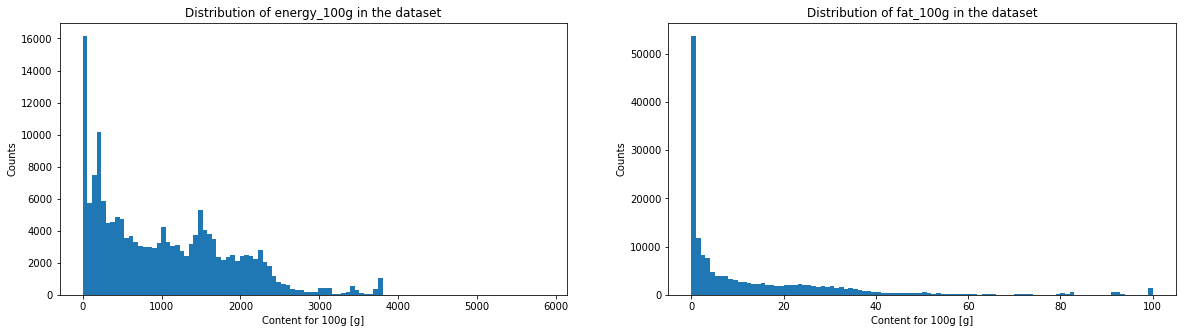

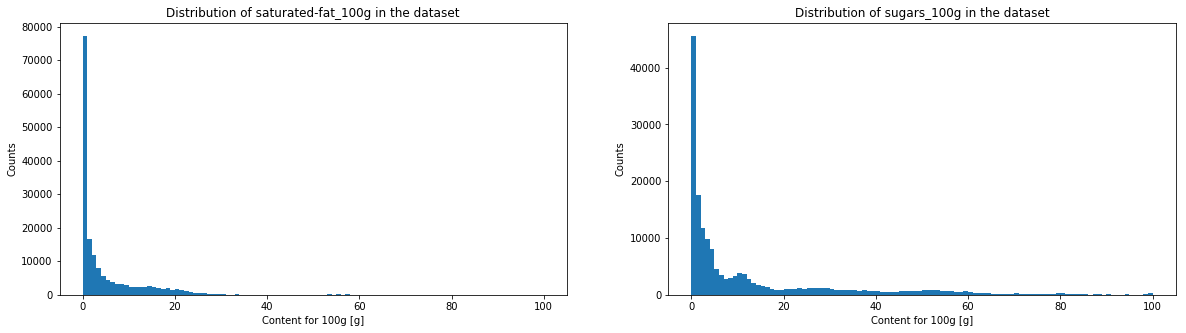

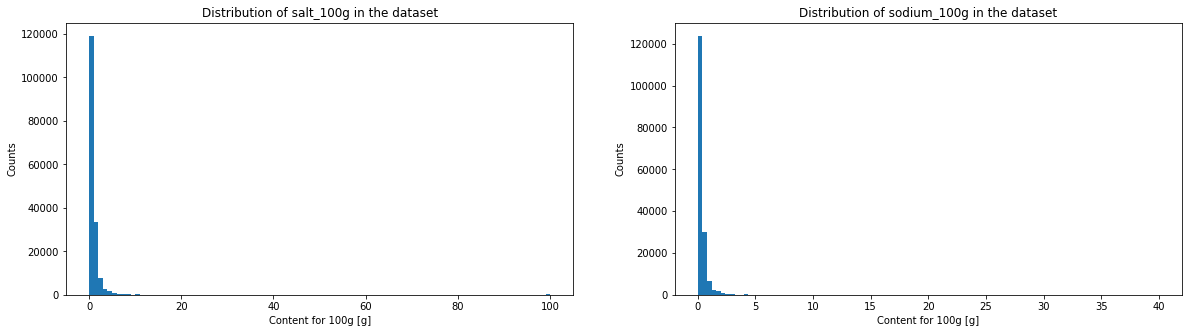

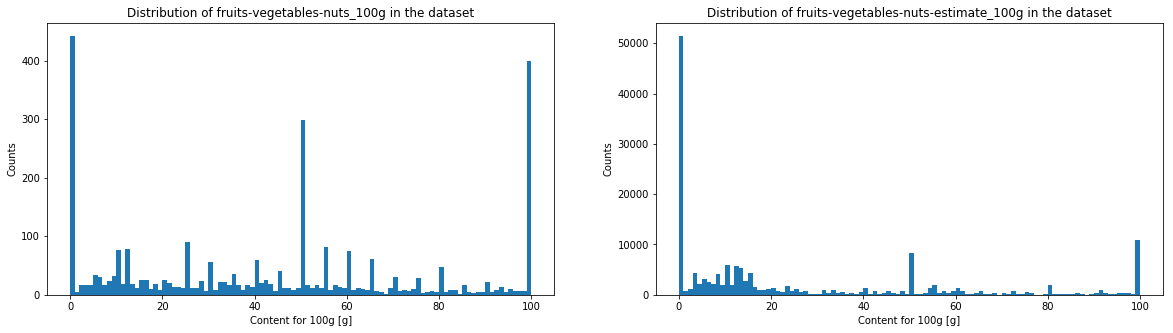

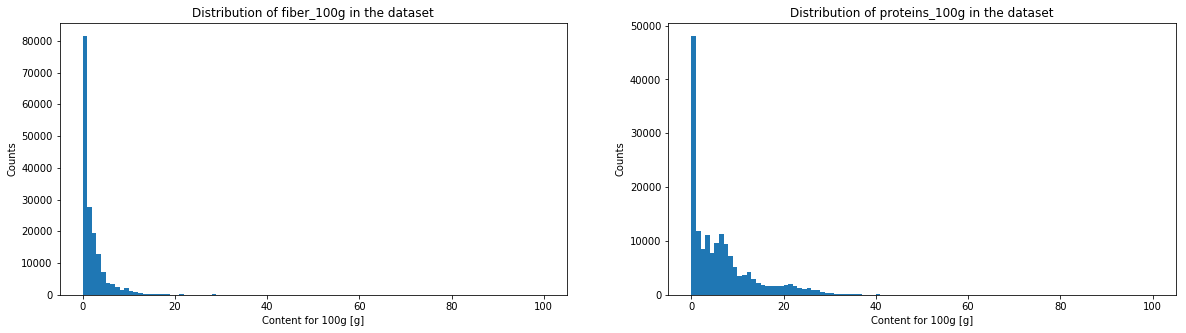

In [45]:
i = 1
for index in range(2, len(data_food_final.columns)):
    column = data_food_final.columns[index]

    if i > 2:
        i = i - 2
    if i == 1:
        plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, i)
   
    plt.hist(data_food_final[column], bins = 100, histtype = 'stepfilled');
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts');
    plt.xlabel('Content for 100g [g]');
    plt.axis('tight');
    if i == 2:
        plt.show()
    i = i + 1

The histogramms of sugar, fat, saturate fat, salt, sodium, fiber and proteins have a very similar aspect. We will see in the following graph if it is correspond to a power law.
    
The energy histogram is a bit more spread in higher values. Both fruit content look very destructured, but it is not surprising as most of these values are estimates. Moreover, the Nutri-Score algorithm make the distinction between large categories : <40%, >40%, >60% and >80%. Therefore, the estimation of fruit content do not have to be precise, but rather to give a more general idea. However, there is no solid convention for the estimation.

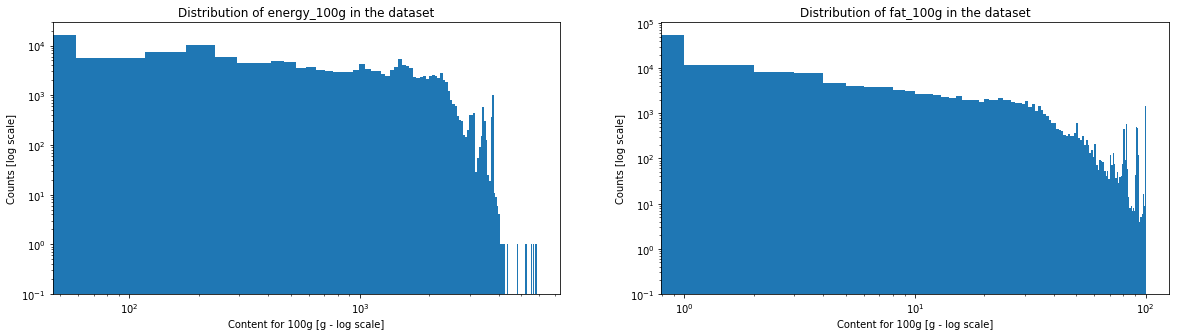

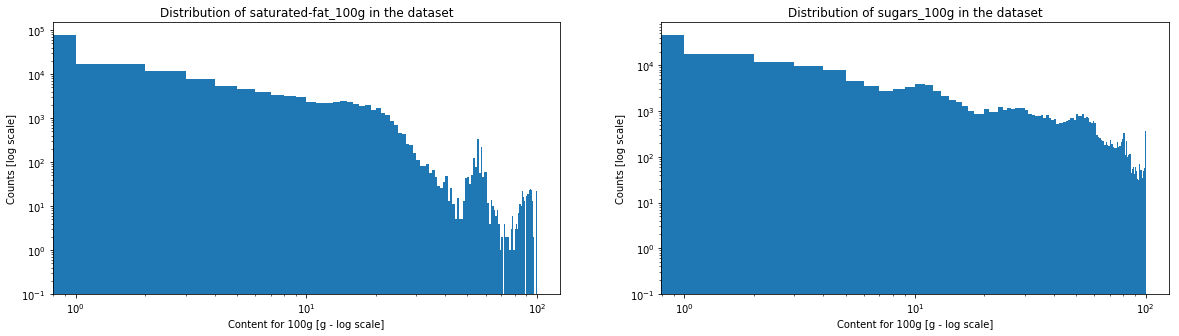

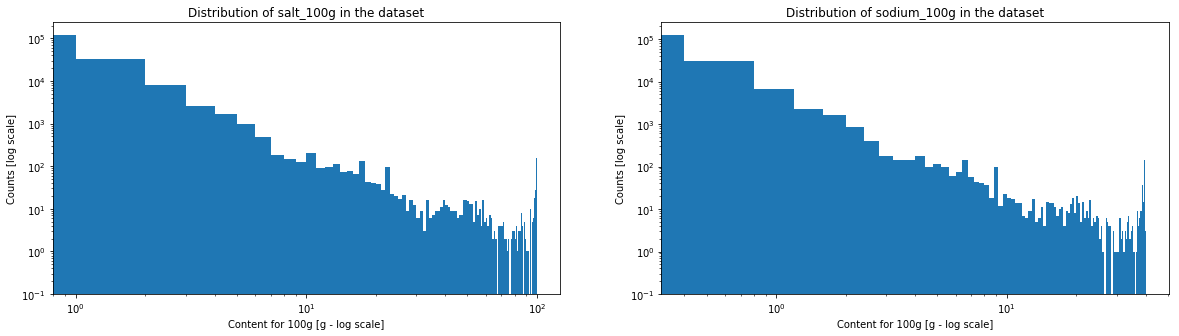

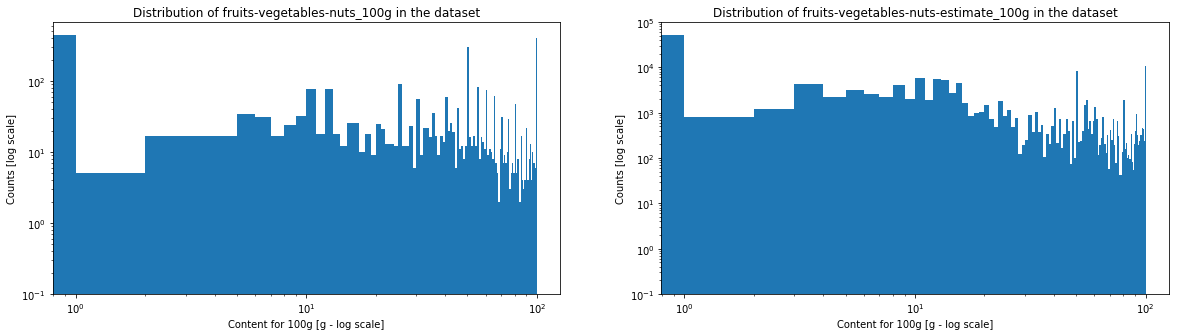

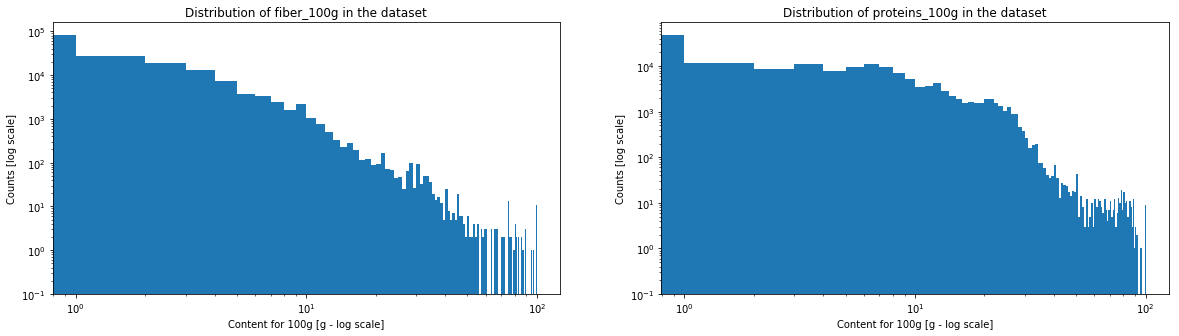

In [51]:
i = 1
for index in range(2, len(data_food_final.columns)):
    column = data_food_final.columns[index]

    if i > 2:
        i = i - 2
    if i == 1:
        plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, i)
   
    plt.hist(data_food_final[column], bins = 100, histtype = 'stepfilled', log = True);
    plt.title('Distribution of {} in the dataset'.format(column));
    plt.ylabel('Counts [log scale]');
    plt.xlabel('Content for 100g [g - log scale]');
    plt.xscale('log');
    plt.axis('tight');
    if i == 2:
        plt.show()
    i = i + 1

We see that salt and sodium may represent a power law caracterised by the straight line. Fiber and sugar also have a similar aspect. We obersve that proteins, energy, fat and saturated-fat have a horizontal line at the begining and at the end a drop in the counts. 

In [52]:
data_food_final.corr(method ='pearson')

,energy_100g,fat_100g,saturated-fat_100g,sugars_100g,salt_100g,sodium_100g,fruits-vegetables-nuts_100g,fruits-vegetables-nuts-estimate_100g,fiber_100g,proteins_100g
energy_100g,1.000000,0.817869,0.626831,0.319871,-0.023507,-0.023510,-0.171717,-0.245808,0.229026,0.271525
fat_100g,0.817869,1.000000,0.733552,-0.033292,-0.003381,-0.003385,-0.166035,-0.200962,0.065585,0.169655
saturated-fat_100g,0.626831,0.733552,1.000000,0.061045,-0.006936,-0.006938,-0.223890,-0.239060,0.027153,0.168513
sugars_100g,0.319871,-0.033292,0.061045,1.000000,-0.077787,-0.077780,0.074202,0.009511,0.047744,-0.194738
salt_100g,-0.023507,-0.003381,-0.006936,-0.077787,1.000000,0.999999,-0.101725,-0.050666,-0.004311,0.063660
sodium_100g,-0.023510,-0.003385,-0.006938,-0.077780,0.999999,1.000000,-0.101723,-0.050664,-0.004314,0.063649
fruits-vegetables-nuts_100g,-0.171717,-0.166035,-0.223890,0.074202,-0.101725,-0.101723,1.000000,0.999981,0.134036,-0.214541
fruits-vegetables-nuts-estimate_100g,-0.245808,-0.200962,-0.239060,0.009511,-0.050666,-0.050664,0.999981,1.000000,0.144027,-0.205393
fiber_100g,0.229026,0.065585,0.027153,0.047744,-0.004311,-0.004314,0.134036,0.144027,1.000000,0.183465
proteins_100g,0.271525,0.169655,0.168513,-0.194738,0.063660,0.063649,-0.214541,-0.205393,0.183465,1.000000


There are many interesting correlations. 

The energy is highly correlated to fat and saturated fat, and moderately to sugar, fiber and proteins. This is a coherent correlation as it is those nutrients which are the source of energy.
Saturated fat is highly correlated to fat as the first is a subcategory of the second.
Sodium and salt are perfectly correlated as the have a fixed ration salt/sodium of 2.5.
Both fruit content, real and estimated, are perfectly correlated due to the cleaning. Estimated fruits content has a moderated negative correlation with energy, fat and saturated fat. But it is interesting that both fruits content and sugar are not correlate even if the fruits-vegetable-nuts content increase sugars content of a product. 

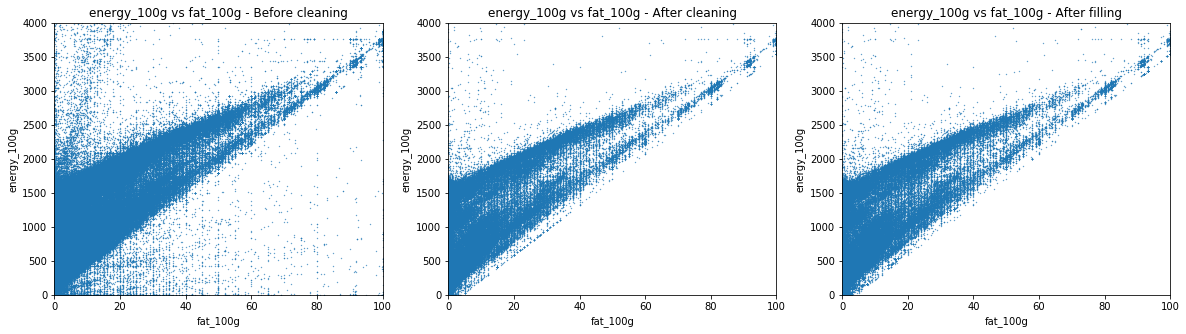

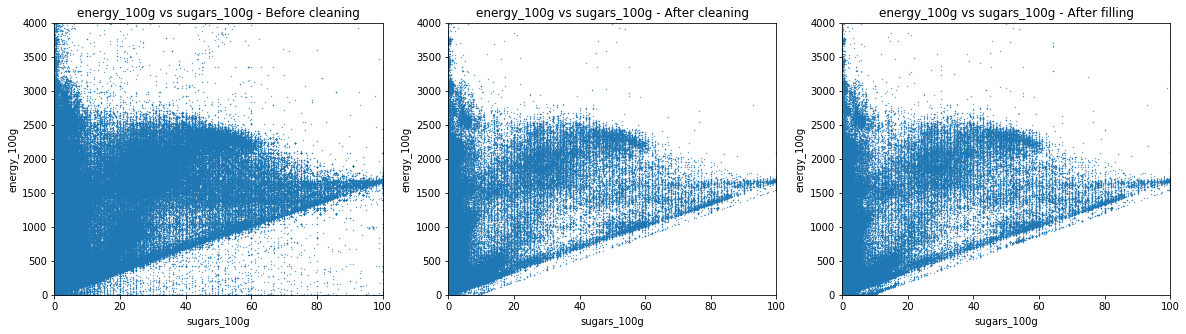

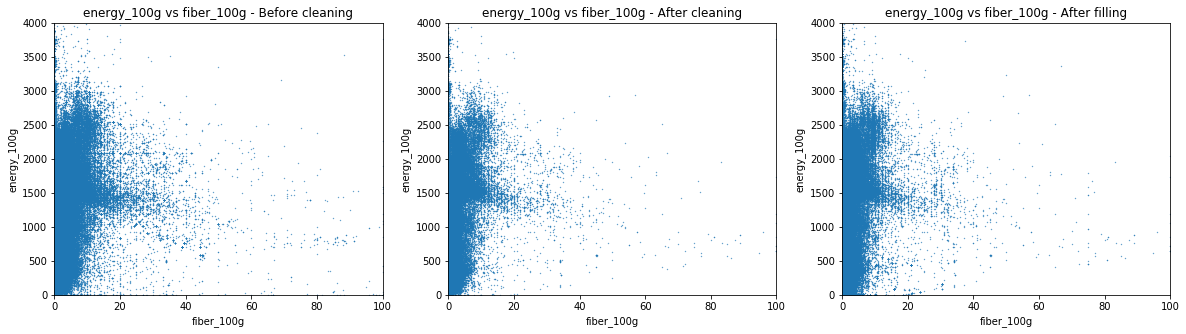

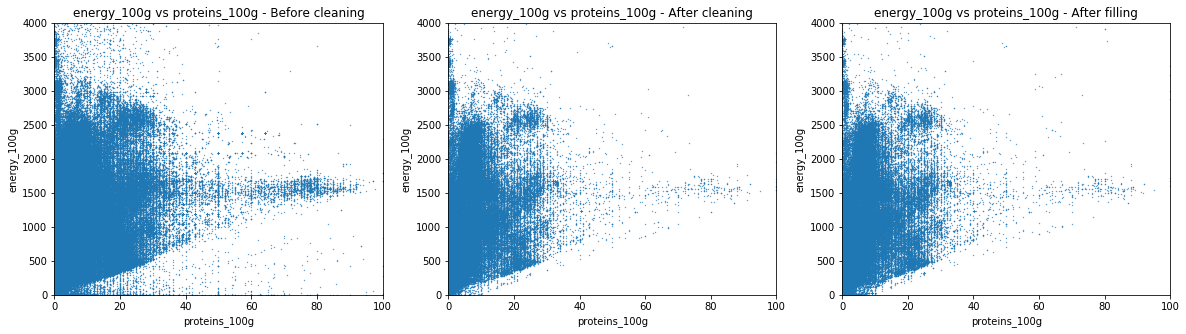

In [53]:
plt_with_energy = [3, 5, 10, 11]

for i_col in range(len(plt_with_energy)):
    x_col = data_food_final.columns[plt_with_energy[i_col]]
    
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data_raw[x_col],data_raw['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - Before cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);
    
    plt.subplot(1, 3, 2)
    plt.scatter(data_food[x_col],data_food['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After cleaning'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);
    

    plt.subplot(1, 3, 3)
    plt.scatter(data_food_final[x_col],data_food_final['energy_100g'], s=0.1);
    plt.title('energy_100g vs {} - After filling'.format(x_col));
    plt.xlabel(x_col);
    plt.ylabel('energy_100g');
    plt.axis([0, 100, 0, 4000]);

    plt.show()
    

We used these scatter plots in order to have better insights of the data and get cues about the cleaning possibilites.

The dirty fat-to-energy plot shows a triangular shape. The low side has a slope of 37kJ, which is the energy density of a gram of fat. The triangular shape comes from a spread in low values of fat. This is due to the presence of sugar, proteins and fibers which also contribute to the energy of a product. As the amount of fat increase, it becomes the main source of energy. The cleaning set a minimum energy amount based on the other nutrients values, minus a a constant for a margin of error.

The other graphs have similar behaviour. The slopes are 17 for sugar and proteins and 8 for fibers.

We observe that the major cleaning of the database is before the filling of it, as expected. The distribution of the scatter plot is identical compare before the filling.

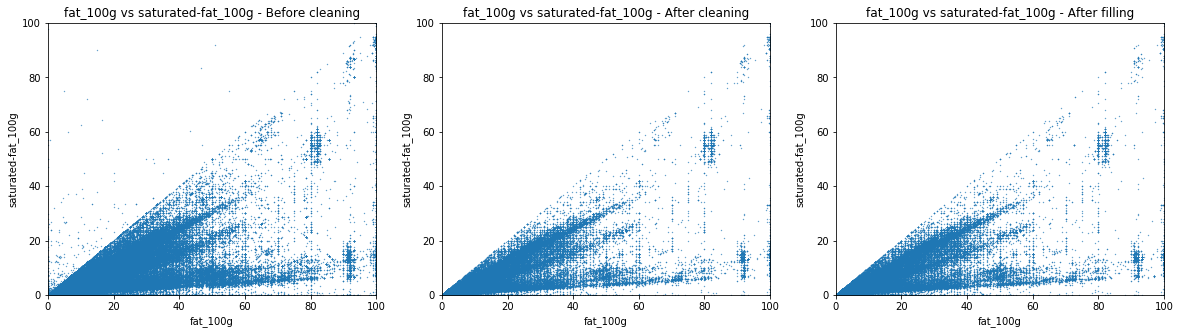

In [54]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['fat_100g'],data_raw['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - Before cleaning');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food['fat_100g'],data_food['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After cleaning');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['fat_100g'],data_food_final['saturated-fat_100g'], s=0.1);
plt.title('fat_100g vs saturated-fat_100g - After filling');
plt.xlabel('fat_100g');
plt.ylabel('saturated-fat_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

The dirty scatter plot indicates that some product have a higher value of saturated fat than fat, which is impossible. As the criterion used in Nutri-Score is the amount of saturated fat, we then set for erroneous product the amount of fat up to the amount of saturated fat. This is a conservative way of cleaning as it tends to penalize products.

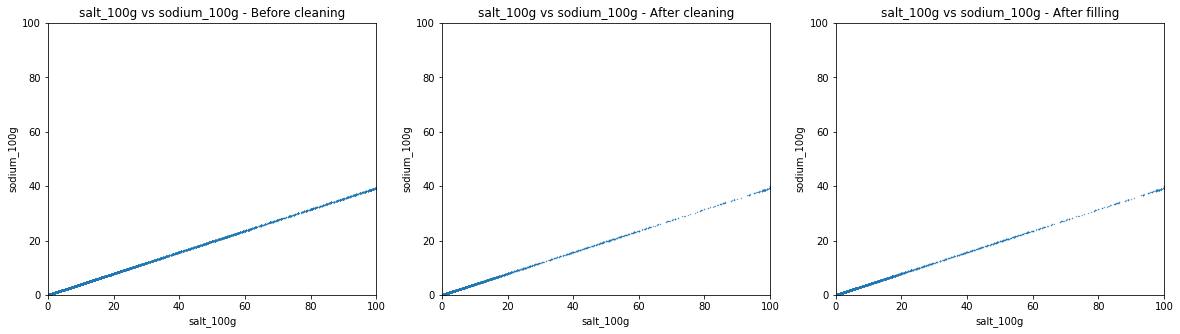

In [55]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['salt_100g'],data_raw['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - Before cleaning');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food['salt_100g'],data_food['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - After cleaning');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['salt_100g'],data_food_final['sodium_100g'], s=0.1);
plt.title('salt_100g vs sodium_100g - After filling');
plt.xlabel('salt_100g');
plt.ylabel('sodium_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

The slope of the scatter plot is 2.5 as expected. Most of the data is clean, changes are minor.

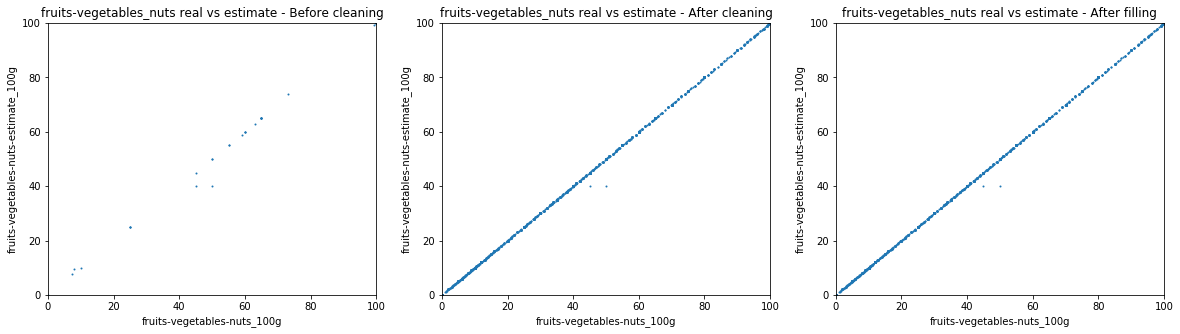

In [56]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.scatter(data_raw['fruits-vegetables-nuts_100g'],data_raw['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - Before cleaning');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 2)
plt.scatter(data_food_final['fruits-vegetables-nuts_100g'],data_food_final['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After cleaning');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);

plt.subplot(1, 3, 3)
plt.scatter(data_food_final['fruits-vegetables-nuts_100g'],data_food_final['fruits-vegetables-nuts-estimate_100g'], s=1);
plt.title('fruits-vegetables_nuts real vs estimate - After filling');
plt.xlabel('fruits-vegetables-nuts_100g');
plt.ylabel('fruits-vegetables-nuts-estimate_100g');
plt.axis([0, 100, 0, 100]);
plt.show()

This display mostly the completion during the cleaning part.

In [57]:
data_nutriscore = data_clean[['nutrition-score-fr_100g','nutrition_grade_fr']]

data_food_nutri = pd.merge(data_nutriscore,data_food_final, on = 'code' )

data_food_nutri = data_food_nutri[~data_food_nutri.nutrition_grade_fr.isna()]

data_food_nutri_beverages = data_food_nutri[data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False)]
data_food_nutri_non_beverages = data_food_nutri[~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

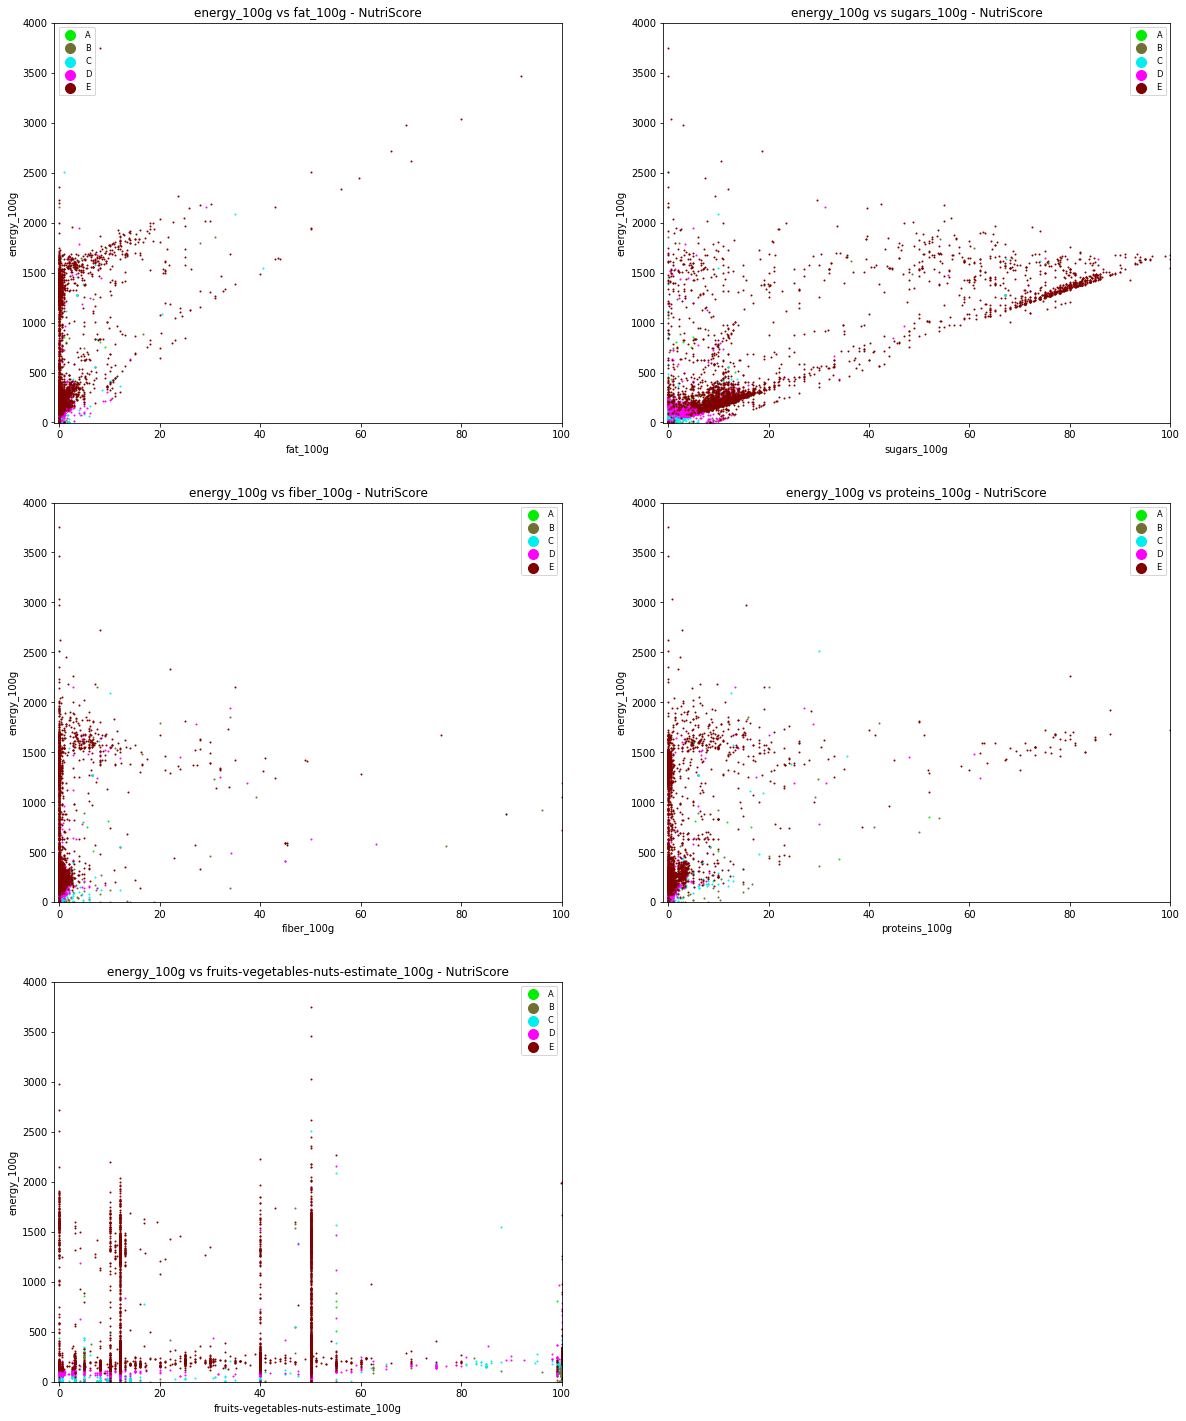

In [59]:
data_food_nutri_beverages_A = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_beverages_B = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_beverages_C = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_beverages_D = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_beverages_E = data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == 'e']

Color = ['#00ee00','#707030', '#00eeee', '#ff00ff', '#800000']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fat_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fat_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fat_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fat_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fat_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['sugars_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['sugars_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['sugars_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['sugars_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['sugars_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fiber_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fiber_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fiber_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fiber_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fiber_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['proteins_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['proteins_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['proteins_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['proteins_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['proteins_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);


Here we do scatter plot for product that we will concider as beverages for our Nutri-Score alogirthm. We observe that most of beverages has low level of fats but are more spread for sugars and proteins. We see that worst grade (E) have largest value of enery, sugars and proteins and mostly have less than 50% of fruits/vegetables/nuts content. The other grades are very condens. If we have to do machine learning with them, it would be difficult because we can not differentiate them. 

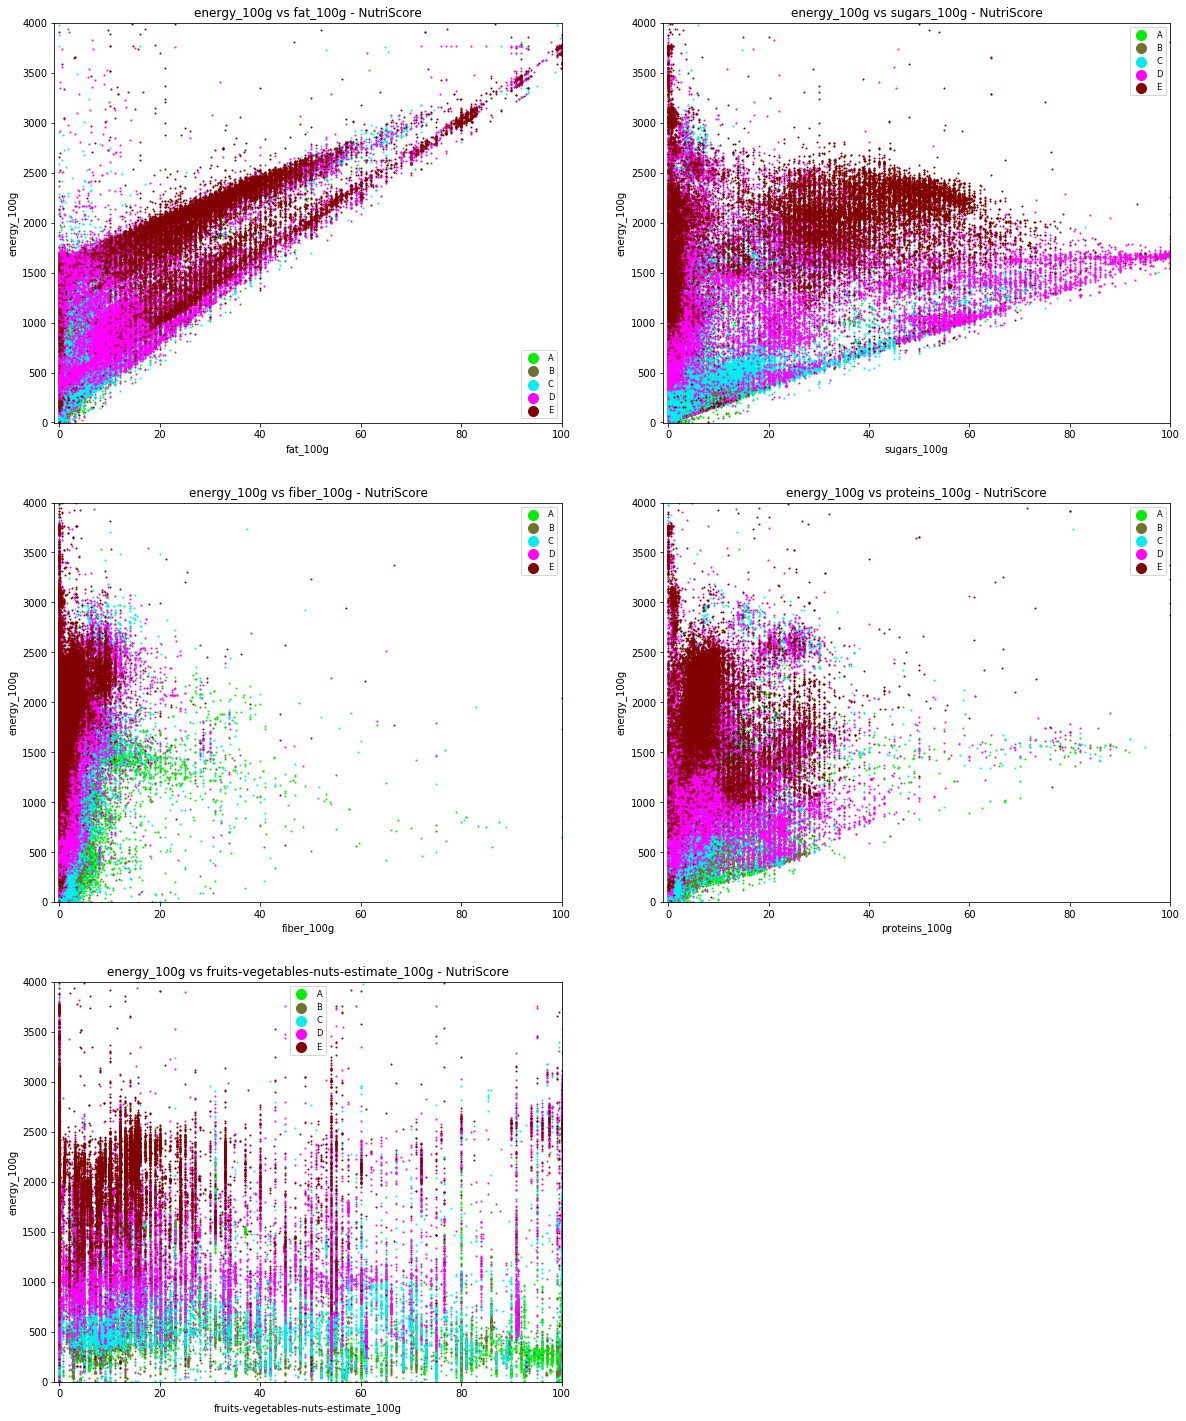

In [60]:
data_food_nutri_non_beverages_A = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'a']
data_food_nutri_non_beverages_B = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'b']
data_food_nutri_non_beverages_C = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'c']
data_food_nutri_non_beverages_D = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'd']
data_food_nutri_non_beverages_E = data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == 'e']

Color = ['#00ee00','#707030', '#00eeee', '#ff00ff', '#800000']


fig = plt.figure(figsize=(20, 25))
ax = fig.add_subplot(321)
plt.title('energy_100g vs fat_100g - NutriScore');
plt.xlabel('fat_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fat_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fat_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fat_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fat_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fat_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(322)
plt.title('energy_100g vs sugars_100g - NutriScore');
plt.xlabel('sugars_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['sugars_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['sugars_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['sugars_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['sugars_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['sugars_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(323)
plt.title('energy_100g vs fiber_100g - NutriScore');
plt.xlabel('fiber_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fiber_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fiber_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fiber_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fiber_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fiber_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(324)
plt.title('energy_100g vs proteins_100g - NutriScore');
plt.xlabel('proteins_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['proteins_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['proteins_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['proteins_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['proteins_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['proteins_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

ax = fig.add_subplot(325)
plt.title('energy_100g vs fruits-vegetables-nuts-estimate_100g - NutriScore');
plt.xlabel('fruits-vegetables-nuts-estimate_100g');
plt.ylabel('energy_100g');
plt.axis([-1, 100, -1, 4000]);

ax.scatter(data_food_nutri_non_beverages_A['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_A['energy_100g'], label = 'A', s = 1);
ax.scatter(data_food_nutri_non_beverages_B['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_B['energy_100g'], label = 'B', s = 1);
ax.scatter(data_food_nutri_non_beverages_C['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_C['energy_100g'], label = 'C', s = 1);
ax.scatter(data_food_nutri_non_beverages_D['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_D['energy_100g'], label = 'D', s = 1);
ax.scatter(data_food_nutri_non_beverages_E['fruits-vegetables-nuts-estimate_100g'],data_food_nutri_non_beverages_E['energy_100g'], label = 'E', s = 1);

for t,j1 in enumerate(ax.collections):
    j1.set_color(Color[t])
ax.legend(fontsize='small', markerscale = 10);

We see that grades C/D/E have the same properties. They have a large window of values for for fats and sugars. But we see according to fruits content vs energy, that we can differentiate the grades according to their energy content because we observe several layers. Grade A have largest amount of fiber that is logical because fiber give negative points for the Nutri-Score.

### NutriScore - Computation

We compute our Nutri-Score algorithm on the database where we know the true grade so we can test our algorithm and try to increase its efficacity.

In [61]:
data_food_nutri['Predicted_NutriScore_grade'] = np.nan
data_food_nutri['Predicted_NutriScore_score'] = np.nan

for index in range(len(data_food_nutri)):

    product = data_food_nutri.iloc[[index]]
    nutriscore, final_score = computeNutriScore(product)
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_grade'] = nutriscore
    data_food_nutri.loc[product.index[0], 'Predicted_NutriScore_score'] = final_score

In [62]:
y_true = data_food_nutri['nutrition_grade_fr']
y_pred = data_food_nutri['Predicted_NutriScore_grade']
labels = ['a', 'b', 'c', 'd', 'e', 'Error']
confusion_matrix_ = confusion_matrix(y_true, y_pred, labels=labels)
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=labels), index = labels, columns = labels)

,a,b,c,d,e,Error
a,18314,849,81,11,10,80
b,2916,15828,671,57,65,306
c,1001,2981,24035,822,149,305
d,185,319,6855,32902,353,498
e,9,72,959,3387,26687,330
Error,0,0,0,0,0,0


In [63]:
data_food_nutri_beverages = data_food_nutri[data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False)]
data_food_nutri_non_beverages = data_food_nutri[~(data_food_nutri.categories_tags.str.contains('beverages', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('en:plant-based-foods,', case=False) &\
                                           ~data_food_nutri.categories_tags.str.contains('milk', case=False))]

print("For Beverages :\n")
ratio_grade = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition_grade_fr'] == data_food_nutri_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_beverages)
ratio_score = len(data_food_nutri_beverages[data_food_nutri_beverages['nutrition-score-fr_100g'] == data_food_nutri_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

print("For non-Beverages :\n")
ratio_grade = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition_grade_fr'] == data_food_nutri_non_beverages['Predicted_NutriScore_grade']])*\
    100 / len(data_food_nutri_non_beverages)
ratio_score = len(data_food_nutri_non_beverages[data_food_nutri_non_beverages['nutrition-score-fr_100g'] == data_food_nutri_non_beverages['Predicted_NutriScore_score']])*\
    100 / len(data_food_nutri_non_beverages)

print('The accuracy according to the grade is {} %, the accuracy according to the score is {} %.\n'.\
          format(ratio_grade,ratio_score))

For Beverages :

The accuracy according to the grade is 87.32627820986868 %, the accuracy according to the score is 54.04819584342726 %.

For non-Beverages :

The accuracy according to the grade is 83.02127625627239 %, the accuracy according to the score is 58.40001276415824 %.



We see that we do a good accuracy for beverages and non-beverages according to the grade. The algorithm raise low number of errors that is due to a missing values. 